In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from src.utils.custom_formatter import setup_custom_logger
logger = setup_custom_logger(__name__, level=logging.DEBUG)

- Load dataset to have actual returns and market returns

In [3]:
from src import Analyzer
from src.utils.params import ReturnParams

import numpy as np

return_params = ReturnParams(
    horizons={},  
    start_date=None,
    end_date="2020-02-03",
    cumulative=False,
    append_start=False
)

an = Analyzer(compare_tickers=[], return_params=return_params, stocks_only=False, weights_application="wealth", dl_kwargs={"weights_method":"dollar"})


ret, hor = an.build_returns()

ret = (np.exp(ret) -1)*100
ret

2025-04-30 20:41:30,778 - src.analyzer - INFO - ############################## Analysis Started ############################## (analyzer.py:80)
2025-04-30 20:41:39,801 - src.analyzer - WARNING - Empty dataframe produced for tickers: [] (analyzer.py:172)


,rh_portfolio
date,
2018-05-03,-0.602745
2018-05-04,1.683162
2018-05-07,0.852330
2018-05-08,0.413330
2018-05-09,1.028846
...,...
2020-01-28,1.713913
2020-01-29,-0.579647
2020-01-30,-0.322621


In [4]:
import pandas as pd
from config.constants import PROJECT_ROOT

daily_factors = pd.read_csv(f"{PROJECT_ROOT}/jf-datashare/gabriel-cuevas/data/18_rwarh_d_1.csv", index_col=0)
daily_factors.index = pd.to_datetime(daily_factors.index, format="%Y%m%d")
daily_factors[["pfioret100", "xmkt", "rf"]]



daily_factors = daily_factors.merge(ret["rh_portfolio"], left_index=True, right_index=True, how="inner")
daily_factors /= 100 

daily_factors["xr"] = daily_factors["rh_portfolio"] - daily_factors["rf"]
daily_factors += 1

daily_factors = daily_factors[["xr", "xmkt"]]
daily_factors


,xr,xmkt
2018-06-04,1.007919,1.0048
2018-06-05,1.007607,1.0016
2018-06-06,1.009507,1.0086
2018-06-07,0.995381,0.9986
2018-06-08,1.003415,1.0031
...,...,...
2020-01-28,1.017079,1.0102
2020-01-29,0.994144,0.9990
2020-01-30,0.996714,1.0034
2020-01-31,0.981644,0.9826


In [5]:
#monthly_factors = pd.read_csv(f"{PROJECT_ROOT}/jf-datashare/gabriel-cuevas/data/20_rwarh_m_1.csv", index_col=0)
#monthly_factors["xr"] = monthly_factors["pfioret100"] - monthly_factors["rf"]
#monthly_factors = monthly_factors[["xr", "xmkt"]]
#monthly_factors.index = pd.to_datetime(monthly_factors.index, format="%Y%m")
monthly_returns = (daily_factors).resample("M").prod() - 1
monthly_returns += 1
monthly_returns



,xr,xmkt
2018-06-30,1.008236,0.994128
2018-07-31,0.995874,1.032174
2018-08-31,1.070942,1.041184
2018-09-30,1.006036,1.000871
2018-10-31,0.893139,0.923333
2018-11-30,0.999990,1.016996
2018-12-31,0.890604,0.904717
2019-01-31,1.131084,1.066421
2019-02-28,1.054940,1.033878
2019-03-31,1.008846,1.010808


Gamma: -7.0344


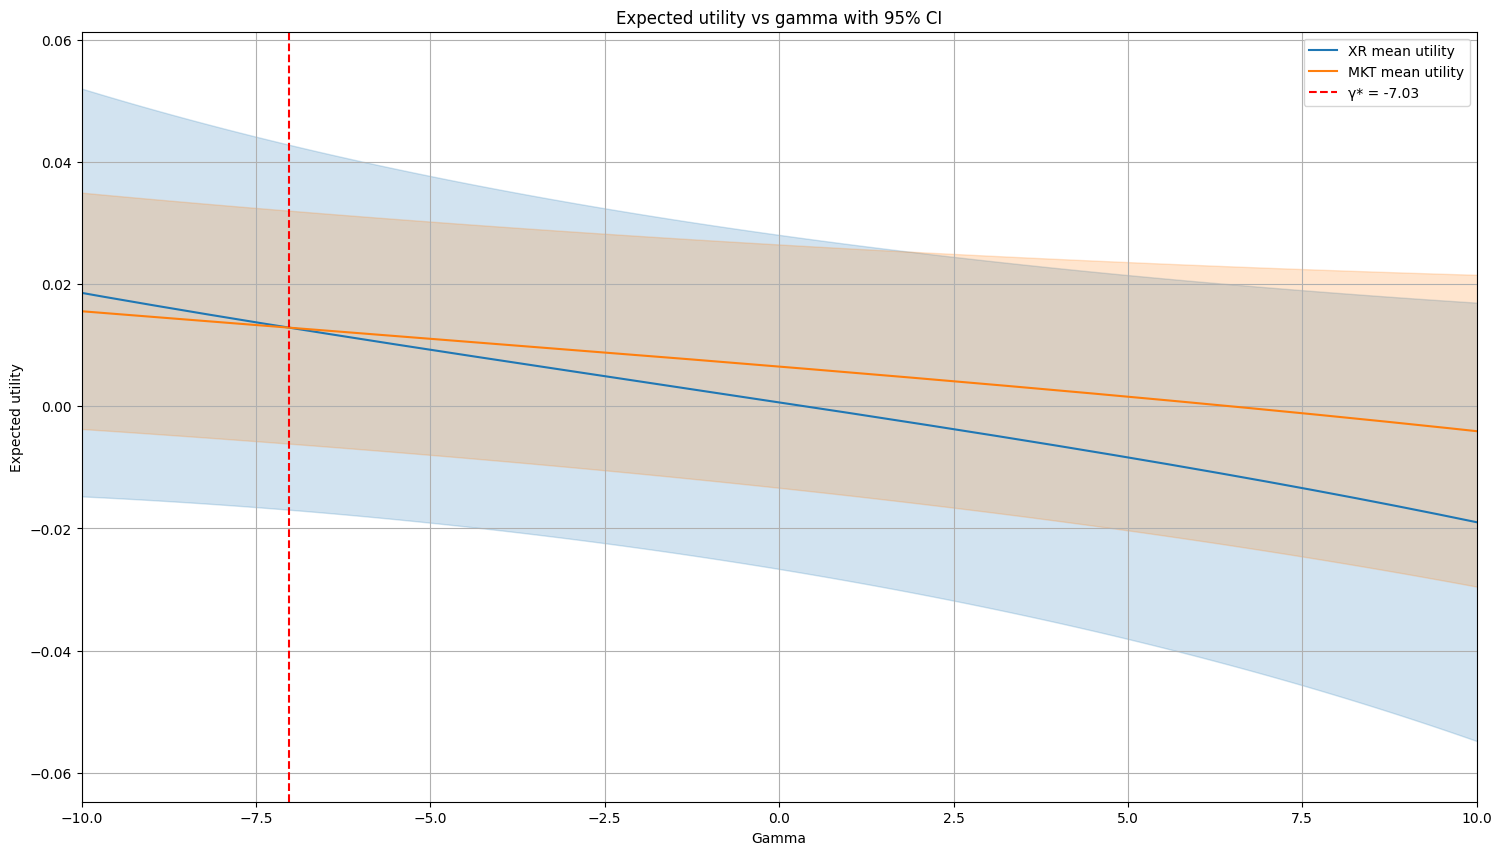

In [6]:
from src.utils.metrics import find_gamma_certainty_equivalent, paramteric_expected_utility_crra, compute_crra_utility


df = monthly_returns
parametric = False



import numpy as np
import matplotlib.pyplot as plt

# keep the scalar returned by the CE condition
gamma_hat = find_gamma_certainty_equivalent(df["xr"],
                                            df["xmkt"],
                                            parametric=parametric)

print(f"Gamma: {gamma_hat:.4f}")

gap = 5
gammas = np.linspace(-11, 11, 1000)

if parametric:
    utilities_xr   = [paramteric_expected_utility_crra(g, df["xr"].values)   for g in gammas]
    utilities_xmkt = [paramteric_expected_utility_crra(g, df["xmkt"].values) for g in gammas]
    plt.figure(figsize=(10, 6))
    plt.plot(gammas, utilities_xr,   label='Portfolio')
    plt.plot(gammas, utilities_xmkt, label='Market')
    plt.axvline(gamma_hat, color='red', linestyle='--', alpha=0.6,
                label=f'γ* = {gamma_hat:.3f}')
    plt.xlabel('Gamma (relative risk-aversion parameter)')
    plt.ylabel('Expected CRRA utility')
    plt.title('Expected utility as a function of gamma')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    utilities_xr   = [compute_crra_utility(df["xr"],   g, confint=True) for g in gammas]
    utilities_xmkt = [compute_crra_utility(df["xmkt"], g, confint=True) for g in gammas]

    means_xr, lo_xr, hi_xr = zip(*utilities_xr)
    means_mk, lo_mk, hi_mk = zip(*utilities_xmkt)

    # Plot
    import matplotlib.pyplot as plt

    plt.figure(figsize=(18,10))
    plt.plot(gammas, means_xr, label='XR mean utility', color='C0')
    plt.fill_between(gammas, lo_xr, hi_xr, color='C0', alpha=0.2)

    plt.plot(gammas, means_mk, label='MKT mean utility', color='C1')
    plt.fill_between(gammas, lo_mk, hi_mk, color='C1', alpha=0.2)

    plt.axvline(gamma_hat, color='red', linestyle='--', label=f'γ* = {gamma_hat:.2f}')
    plt.xlabel('Gamma')
    plt.xlim((-10,10))
    plt.ylabel('Expected utility')
    plt.title('Expected utility vs gamma with 95% CI')
    plt.legend()
    plt.grid(True)
    plt.show()




### All possible timeframes

In [105]:
from src import Analyzer
from src.utils.params import ReturnParams

import numpy as np

return_params = ReturnParams(
    horizons={},  
    start_date=None,
#    end_date="2020-02-03",
    cumulative=False,
    append_start=False
)

an = Analyzer(compare_tickers=[], return_params=return_params, stocks_only=False, weights_application="number", dl_kwargs={"weights_method":"dollar"})


ret, hor = an.build_returns()

ret = (np.exp(ret) -1)*100


2025-05-01 13:52:45,907 - src.analyzer - INFO - ############################## Analysis Started ############################## (analyzer.py:80)
2025-05-01 13:52:56,237 - src.analyzer - WARNING - Empty dataframe produced for tickers: [] (analyzer.py:172)


In [106]:
import pandas as pd
from config.constants import PROJECT_ROOT

daily_factors = pd.read_csv(f"{PROJECT_ROOT}/jf-datashare/gabriel-cuevas/data/18_rwarh_d_1.csv", index_col=0)
daily_factors.index = pd.to_datetime(daily_factors.index, format="%Y%m%d")
daily_factors[["pfioret100", "xmkt", "rf"]]



daily_factors = daily_factors.merge(ret["rh_portfolio"], left_index=True, right_index=True, how="inner")
daily_factors /= 100 

daily_factors["xr"] = daily_factors["rh_portfolio"] - daily_factors["rf"]
daily_factors += 1

daily_factors = daily_factors[["xr", "xmkt", "rf", "rh_portfolio"]]


In [107]:
df_merged = daily_factors
levels = df_merged.cumprod()
levels

,xr,xmkt,rf,rh_portfolio
2018-06-04,1.007066,1.004800,1.000060,1.007126
2018-06-05,1.016970,1.006408,1.000120,1.017091
2018-06-06,1.018468,1.015063,1.000180,1.018650
2018-06-07,1.016224,1.013642,1.000240,1.016467
2018-06-08,1.010911,1.016784,1.000300,1.011213
...,...,...,...,...
2020-08-07,1.092819,1.184561,1.036033,1.132254
2020-08-10,1.091944,1.187404,1.036033,1.131347
2020-08-11,1.070693,1.177548,1.036033,1.109329
2020-08-12,1.115996,1.194034,1.036033,1.156266


In [108]:
# Set doesnt allow to duplicate items
all_windows = set()

# get dates to iterate on
dates = df_merged.index.unique()


for date1 in dates:
    for date2 in dates:
        # Order the dates so that i dont have problems in computing reteurns and i dont have tuples with the same value in different order 
        if date2>date1:

            inner_tuple = (date1, date2)
            all_windows.add(inner_tuple)


all_windows = list(all_windows)


In [109]:
from tqdm import tqdm
import pandas as pd
import numpy as np

all_ret = []
for window in tqdm(all_windows):

    # get first and last value (days)
    beg = window[0]
    end = window[1]
    
    # Compute days between them

    # compute gross returns
    ret = levels.loc[end]/levels.loc[beg]

    all_ret.append(ret)


# Create DataFrame from the list of Series
all_ret_df = pd.DataFrame(all_ret)

# Assign MultiIndex with start and end dates
all_ret_df.index = pd.MultiIndex.from_tuples(all_windows, names=["start_date", "end_date"])

all_ret_df['date_difference'] = all_ret_df.index.map(lambda x: (x[1] - x[0]).days)



100%|██████████| 144991/144991 [00:19<00:00, 7542.74it/s]


In [110]:
all_ret_df["zero"] = 0
all_ret_df

,,xr,xmkt,rf,rh_portfolio,date_difference,zero
start_date,end_date,,,,,,
2018-11-29,2019-07-29,0.873685,1.077742,1.015163,0.886946,242,0
2018-07-02,2020-02-11,0.784215,1.163708,1.032599,0.809801,589,0
2018-06-26,2020-06-09,0.714308,1.125190,1.034976,0.739329,714,0
2019-12-23,2020-07-30,1.363154,1.005245,1.003596,1.368087,220,0
2018-07-23,2019-04-10,0.841505,1.005039,1.015194,0.854306,261,0
...,...,...,...,...,...,...,...
2018-08-16,2020-07-24,0.944005,1.085925,1.032330,0.974579,708,0
2018-09-11,2020-02-06,0.724152,1.087688,1.028754,0.744998,513,0
2018-09-04,2018-10-10,0.877994,0.951545,1.002082,0.879831,36,0


Gamma: -5.4373


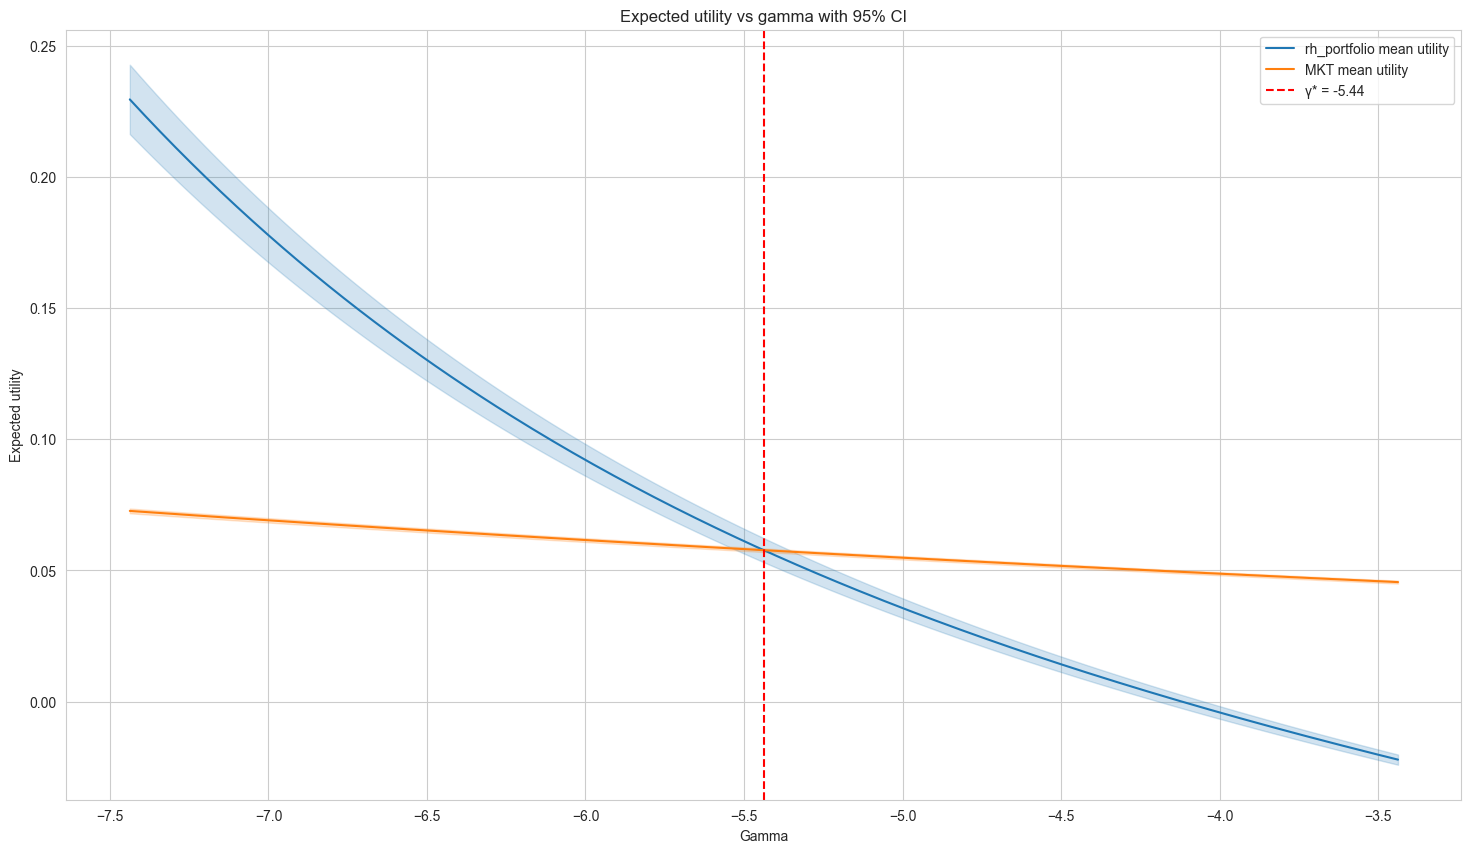

In [111]:
from src.utils.metrics import find_gamma_certainty_equivalent, paramteric_expected_utility_crra, compute_crra_utility


df = all_ret_df
parametric = False
mkt = "xmkt"



import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_style("whitegrid")

# keep the scalar returned by the CE condition
gamma_hat = find_gamma_certainty_equivalent(df["xr"],
                                            df[mkt],
                                            parametric=parametric)

print(f"Gamma: {gamma_hat:.4f}")

gamma_hat = gamma_hat if gamma_hat is not np.nan else 0

gap = 2
gammas = np.linspace(gamma_hat-gap, gamma_hat+gap, 250)

if parametric:
    utilities_rh_portfolio   = [paramteric_expected_utility_crra(g, df["xr"].values)   for g in gammas]
    utilities_xmkt = [paramteric_expected_utility_crra(g, df[mkt].values) for g in gammas]

    plt.figure(figsize=(10, 6))
    plt.plot(gammas, utilities_rh_portfolio,   label='Portfolio')
    plt.plot(gammas, utilities_xmkt, label='Market')
    plt.axvline(gamma_hat, color='red', linestyle='--', alpha=0.6,
                label=f'γ* = {gamma_hat:.3f}')
    plt.xlabel('Gamma (relative risk-aversion parameter)')
    plt.ylabel('Expected CRRA utility')
    plt.title('Expected utility as a function of gamma')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    utilities_rh_portfolio   = [compute_crra_utility(df["xr"],   g, confint=True) for g in gammas]
    utilities_xmkt = [compute_crra_utility(df[mkt], g, confint=True) for g in gammas]

    means_rh_portfolio, lo_rh_portfolio, hi_rh_portfolio = zip(*utilities_rh_portfolio)
    means_mk, lo_mk, hi_mk = zip(*utilities_xmkt)

    plt.figure(figsize=(18,10))
    plt.plot(gammas, means_rh_portfolio, label='rh_portfolio mean utility', color='C0')
    plt.fill_between(gammas, lo_rh_portfolio, hi_rh_portfolio, color='C0', alpha=0.2)

    plt.plot(gammas, means_mk, label='MKT mean utility', color='C1')
    plt.fill_between(gammas, lo_mk, hi_mk, color='C1', alpha=0.2)

    plt.axvline(gamma_hat, color='red', linestyle='--', label=f'γ* = {gamma_hat:.2f}')
    plt.xlabel('Gamma')
    plt.ylabel('Expected utility')
    plt.title('Expected utility vs gamma with 95% CI')
    plt.legend()
    plt.grid(True)
    plt.show()




## Euler

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src import Analyzer
from src import RiskTests
from src.utils.params import ReturnParams

import numpy as np

return_params = ReturnParams(
    horizons={},  
    start_date=None,
#    end_date="2020-02-03",
    cumulative=False,
    append_start=False
)

an = Analyzer(compare_tickers=["VOO"], return_params=return_params, stocks_only=False, weights_application="number", dl_kwargs={"weights_method":"dollar"})


rt = RiskTests(an)
daily_factors = rt.factors
daily_factors.describe()

2025-05-01 19:28:48,516 - src.analyzer - INFO - ############################## Analysis Started ############################## (analyzer.py:80)


,rh_portfolio,rf,mkt,xr,xmkt
count,539.000000,539.000000,539.000000,539.000000,539.000000
mean,0.000483,0.000066,0.000458,0.000417,0.000392
std,0.018795,0.000033,0.015970,0.018800,0.015972
min,-0.118804,0.000000,-0.117388,-0.118864,-0.117448
25%,-0.006699,0.000060,-0.003947,-0.006789,-0.004021
50%,0.000606,0.000070,0.000908,0.000526,0.000876
75%,0.008930,0.000090,0.006568,0.008845,0.006483
max,0.075525,0.000100,0.095364,0.075465,0.095304


In [43]:
monnthly_factors = rt.resample_factors()
monnthly_factors

,rh_portfolio,rf,mkt,xr,xmkt
2018-06-30,0.005810,0.001201,-0.007557,0.004604,-0.008748
2018-07-31,0.027435,0.001681,0.035630,0.025713,0.033894
2018-08-31,0.064354,0.001471,0.040571,0.062795,0.039045
2018-09-30,-0.030532,0.001521,0.001237,-0.032007,-0.000283
2018-10-31,-0.098458,0.001842,-0.068377,-0.100123,-0.070095
2018-11-30,-0.002843,0.001681,0.018851,-0.004518,0.017142
2018-12-31,-0.114085,0.001902,-0.093380,-0.115779,-0.095110
2019-01-31,0.059488,0.001601,0.061908,0.057800,0.060217
2019-02-28,-0.023432,0.001902,0.032499,-0.025288,0.030542
2019-03-31,0.002686,0.001892,0.013551,0.000793,0.011638


In [4]:
gamma_gmm = rt.estimate_euler_gamma(df_returns=daily_factors)
gamma_gmm

np.float64(2.8753855998809206)

Gamma: -10.0000


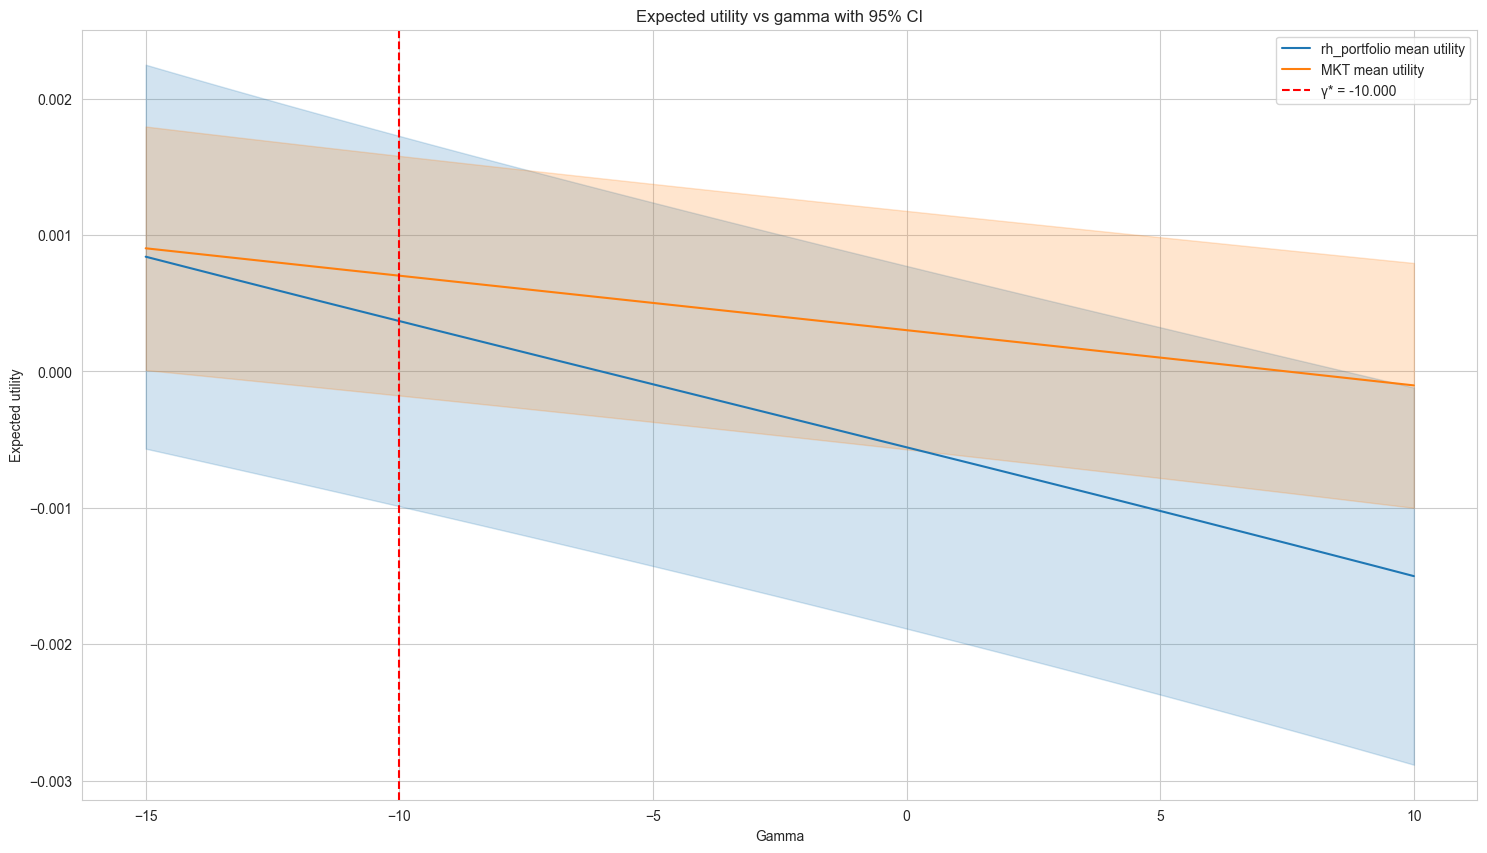

np.float64(-9.999999980286672)

In [45]:
rt.find_cutoff_gamma()

In [46]:
df = daily_factors +1
df

,rh_portfolio,rf,mkt,xr,xmkt
2018-06-04,1.007126,1.00006,1.004415,1.007066,1.004355
2018-06-05,1.009895,1.00006,1.001386,1.009835,1.001326
2018-06-06,1.001532,1.00006,1.007988,1.001472,1.007928
2018-06-07,0.997857,1.00006,0.999529,0.997797,0.999469
2018-06-08,0.994831,1.00006,1.003140,0.994771,1.003080
...,...,...,...,...,...
2020-01-28,1.012218,1.00006,1.010833,1.012158,1.010773
2020-01-29,1.003558,1.00006,0.999001,1.003498,0.998941
2020-01-30,1.008771,1.00006,1.003132,1.008711,1.003072
2020-01-31,0.992740,1.00006,0.982065,0.992680,0.982005


In [5]:
rt.bootstrap_difference_utility(gamma0=gamma_gmm)

100%|██████████| 5000/5000 [00:02<00:00, 1906.14it/s]

ΔU (market - RH) at γ=2.875: 0.00012 [-0.00061, 0.00084]


(np.float64(0.00011600533526851455),
 np.float64(-0.0006076360989113567),
 np.float64(0.000843054899359506))

In [65]:
daily_factors

,rh_portfolio,rf,mkt,xr,xmkt
2018-06-04,0.007126,0.00006,0.004415,0.007066,0.004355
2018-06-05,0.009895,0.00006,0.001386,0.009835,0.001326
2018-06-06,0.001532,0.00006,0.007988,0.001472,0.007928
2018-06-07,-0.002143,0.00006,-0.000471,-0.002203,-0.000531
2018-06-08,-0.005169,0.00006,0.003140,-0.005229,0.003080
...,...,...,...,...,...
2020-08-07,-0.014506,0.00000,0.000521,-0.014506,0.000521
2020-08-10,-0.000801,0.00000,0.003188,-0.000801,0.003188
2020-08-11,-0.019462,0.00000,-0.008075,-0.019462,-0.008075
2020-08-12,0.042312,0.00000,0.013700,0.042312,0.013700


In [ ]:
df_gmm = daily_factors

import numpy as np
from scipy.optimize import minimize_scalar
from tqdm import trange

B = 5_000
n = len(df_gmm)
gamma_boot = np.empty(B)

for b in trange(B):
    # 1) bootstrap sample
    sample = df_gmm.sample(n, replace=True)
    rp_b   = sample['rh_portfolio']
    rf_b   = sample['rf']
    bar_rf = rf_b.mean()

    # 2) define moment for this draw
    def moment_b(g):
        m = (1.0 / (1.0 + bar_rf)) * (1.0 + rp_b) ** (-g)
        return (m * (1.0 + rp_b)).mean() - 1.0

    # 3) minimize squared moment
    obj = lambda g: moment_b(g)**2
    sol = minimize_scalar(obj, bounds=(-50, 50), method='bounded')

    gamma_boot[b] = sol.x if sol.success else np.nan

# drop failed solves
gamma_boot = gamma_boot[~np.isnan(gamma_boot)]

# point estimate & 95% CI
gamma_hat = gamma_boot.mean()
lower, upper = np.percentile(gamma_boot, [2.5, 97.5])

print(f"γ̂^GMM = {gamma_hat:.4f}")
print(f"95% CI = [{lower:.4f}, {upper:.4f}]")


100%|██████████| 5000/5000 [00:26<00:00, 191.23it/s]

γ̂_GMM = 1.0971
95% CI = [-6.5266, 12.1093]


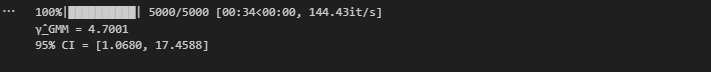

In [ ]:
from scipy.stats import bootstrap
import pandas as pd

# Full‐sample estimate
gamma_hat = rt.estimate_euler_gamma()  # or your_class.estimate_euler_gamma(df_gmm)
print(f"γ̂^GMM = {gamma_hat:.4f}")

# Prepare data for bootstrap
rp = daily_factors["rh_portfolio"]
rf = daily_factors["rf"]
data = (rp, rf)

# Statistic function using your exact solver
def gmm_stat(rp, rf):
    # recompute bar_rf inside the solver
    data = pd.DataFrame({"rh_portfolio":rp,
                         "rf":rf})
    return rt.estimate_euler_gamma(df_returns=data)



# Run BCa bootstrap
res = bootstrap(
    data,
    statistic=gmm_stat,
    paired=True,
    vectorized=False,
    n_resamples=5000,
    method='bca',
    confidence_level=0.95
)

ci = res.confidence_interval
print(f"95% BCa CI = [{ci.low:.4f}, {ci.high:.4f}]")


γ̂_GMM = 2.6863
2
95% BCa CI = [0.4156, 20.6930]


In [13]:
rt.bootstrap_gamma(daily_factors)

TypeError: RiskTests.bootstrap_gamma.<locals>.gmm_stat() takes 1 positional argument but 2 were given

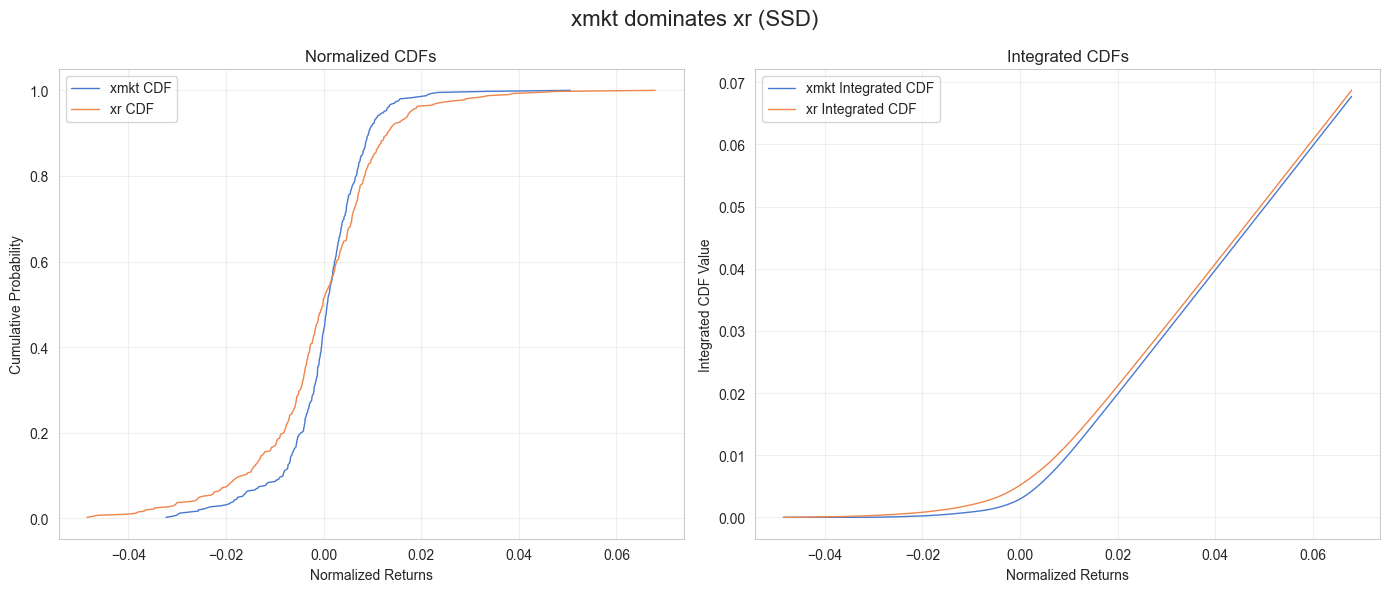

np.True_

In [51]:
from src.visuals.plotter import Plotter, ReturnSeries


plotter = Plotter([ReturnSeries(label="GMM", df=df_gmm, horizons=[])])
plotter.plot_ssd_comparison(df_gmm["mkt"], df_gmm["rh_portfolio"], "xmkt", "xr")